## RNN model fitting

This notebook contains the fitting of the Recurrent Neural Network with LSTM cells to all series in the dataset at the same time.

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from RNN.model_selection import RNNHyperTune
from RNN.data_processing import window_dataset
from DataSimulation.utils import plot_fit

In [2]:
data = pd.read_csv('data.csv', header=None)
data.head()

0      1    2    3    4    5    6      7       8       9   ...   90  \
0  231.0  234.0  8.0  7.0  3.0  6.0  8.0  863.0  1496.0  4851.0  ...  6.0   
1  255.0  260.0  7.0  5.0  5.0  5.0  8.0  931.0  1438.0  4849.0  ...  8.0   
2  244.0  238.0  5.0  4.0  6.0  6.0  7.0  871.0  1412.0  4808.0  ...  9.0   
3  240.0  229.0  3.0  8.0  6.0  6.0  5.0  882.0  1413.0  4781.0  ...  5.0   
4  209.0  258.0  7.0  7.0  6.0  5.0  7.0  885.0  1353.0  4796.0  ...  9.0   

    91     92     93     94     95   96    97   98     99  
0  3.0  408.0  236.0  796.0  487.0  7.0  11.0  2.0  278.0  
1  0.0  388.0  259.0  840.0  475.0  6.0   9.0  2.0  250.0  
2  2.0  397.0  256.0  735.0  484.0  7.0  10.0  0.0  268.0  
3  0.0  389.0  247.0  835.0  384.0  9.0   8.0  2.0  292.0  
4  1.0  355.0  191.0  800.0  461.0  6.0   6.0  1.0  325.0  

[5 rows x 100 columns]

In [3]:
test_size = 4*24
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(904, 100)
(96, 100)


In [4]:
parameters = {
    'lstm_units':[16,32,64],
    'learning_rate':[0.01, 0.001, 0.0001],
    'batch_size':[32,64,128],
}
rnn_hypertune = RNNHyperTune(100, 24, parameters)

In [5]:
rnn_model, scaler = rnn_hypertune.fit(
    data=train_data,
    checkpoint_path=os.path.join(os.getcwd(), 'checkpoint'),
    epochs=500
)

Training model 0/108.
minimum 0 model's validation loss: 0.055901944637298584.
Training model 1/108.
minimum 1 model's validation loss: 0.05400729924440384.
Training model 2/108.
minimum 2 model's validation loss: 0.05918228253722191.
Training model 3/108.
minimum 3 model's validation loss: 0.0583135224878788.
Training model 4/108.
minimum 4 model's validation loss: 0.0565597340464592.
Training model 5/108.
minimum 5 model's validation loss: 0.058053940534591675.
Training model 6/108.
minimum 6 model's validation loss: 0.0589599534869194.
Training model 7/108.
minimum 7 model's validation loss: 0.05815945193171501.
Training model 8/108.
minimum 8 model's validation loss: 0.05865079164505005.
Training model 9/108.
minimum 9 model's validation loss: 0.058206282556056976.
Training model 10/108.
minimum 10 model's validation loss: 0.057862624526023865.
Training model 11/108.
minimum 11 model's validation loss: 0.062282316386699677.
Training model 12/108.
minimum 12 model's validation loss:

tiempo: 246m, 46.1s

In [6]:
rnn_model.summary()

Model: "sequential_109"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_163 (LSTM)             (None, 24, 64)            42240     
                                                                 
 dense_109 (Dense)           (None, 24, 100)           6500      
                                                                 
Total params: 48,740
Trainable params: 48,740
Non-trainable params: 0
_________________________________________________________________


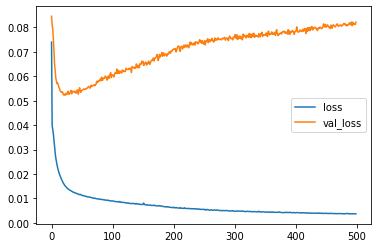

In [7]:
df = pd.DataFrame(rnn_hypertune.history.history)
df.plot(y=['loss', 'val_loss'])
plt.show()

In [8]:
scaled_data = scaler.transform(data)

In [9]:
eval_ds = window_dataset(
    data=scaled_data,
    sequence_lenght=24,
    output_lenght=24,
    batch_size=scaled_data.shape[0],
    shift=1,
    shuffle=False    
)

In [10]:
fit_values = rnn_model.predict(eval_ds)
fit_0 = fit_values[:,0,:]

1/1 [==============================] - 1s 681ms/step


In [11]:
orig_scale = scaler.inverse_transform(fit_0)

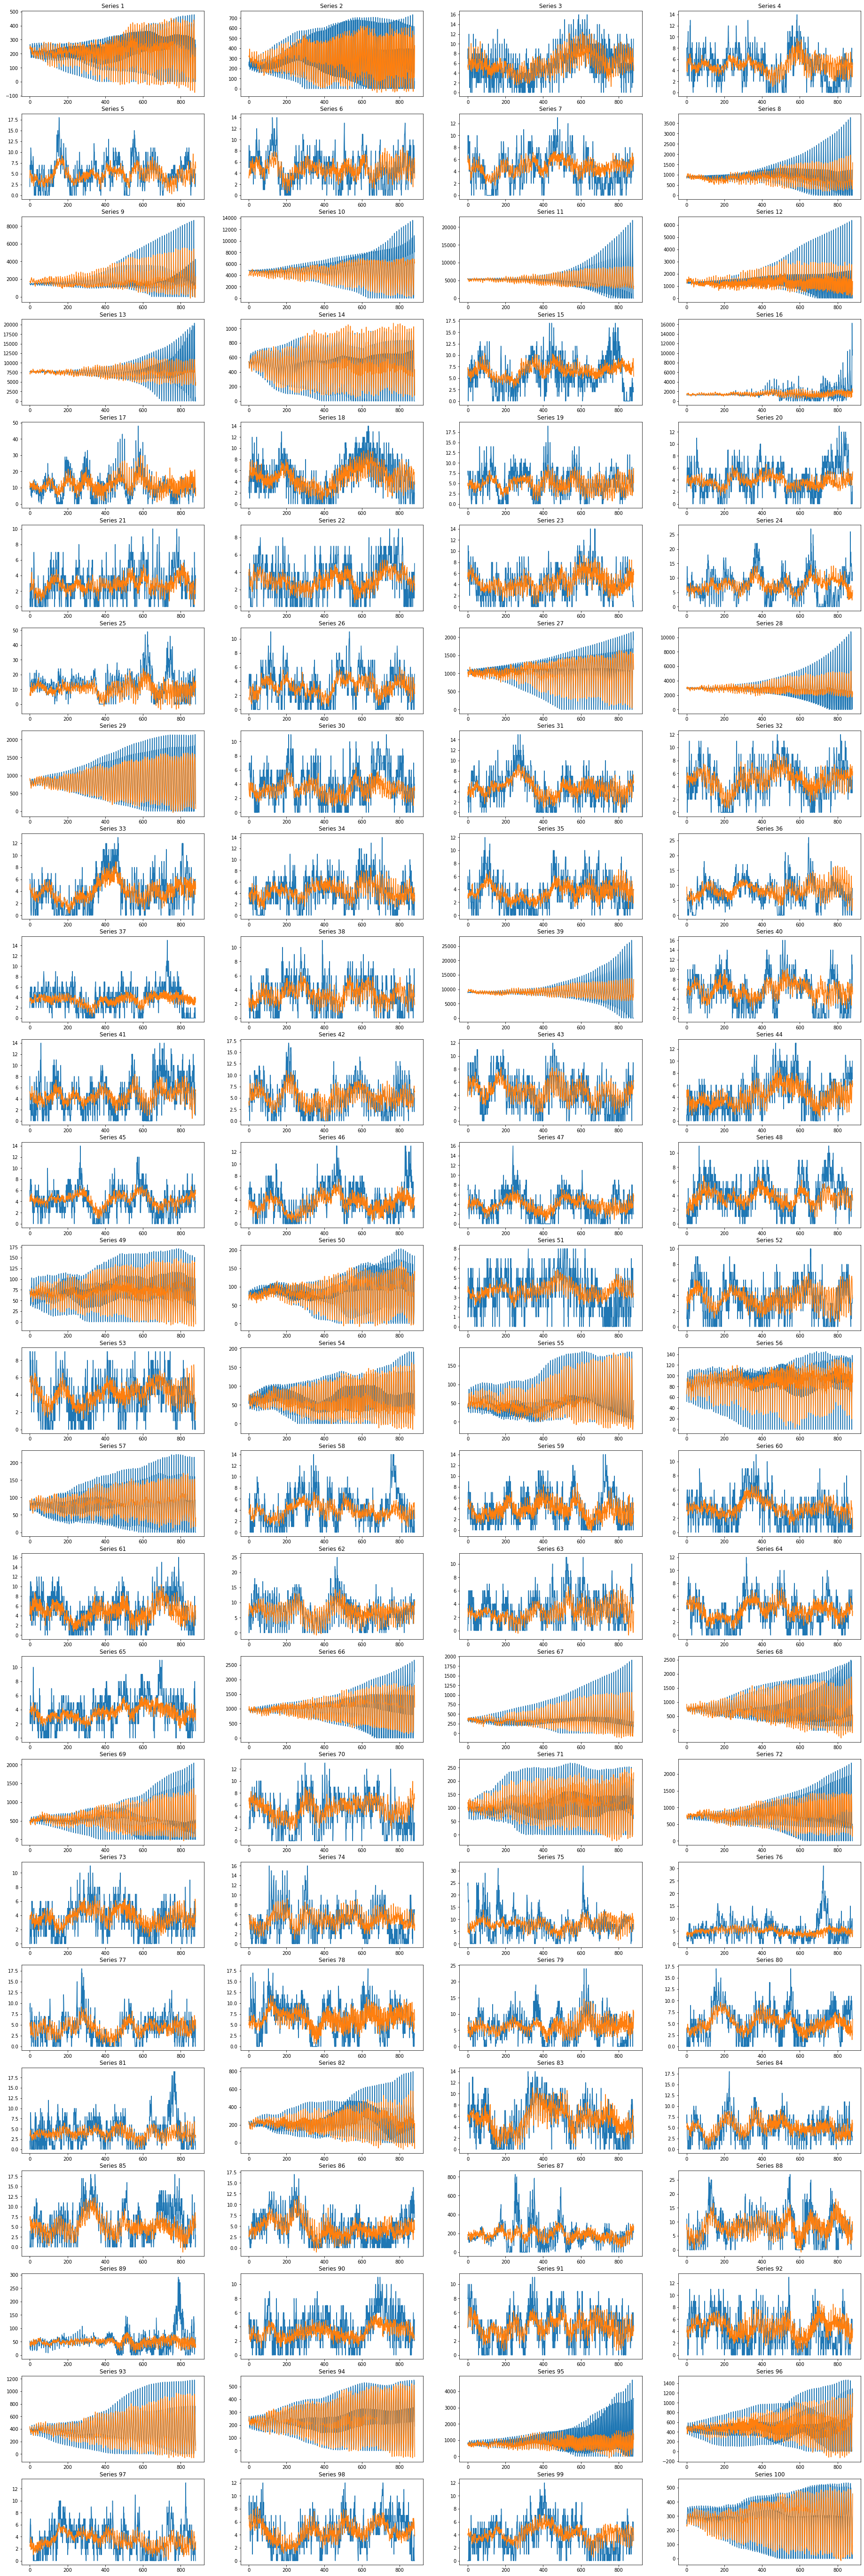

In [12]:
plot_fit(train_data[24:], orig_scale[:-3*24])

In [13]:
rnn_model.save("rnn.h5")

In [14]:
with open("rnn_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)